## Мультимодальные модели

Мультимодальные модели - это модели, которые могут принимать на вход и/или выдавать на выходе разные модальности: картинки, текст, аудио. Внутри они устроены очень сложно, поскольку должны транслировать разные модальности в одно пространство смыслов.

Открытой удобной и недорогой в использовании мультимодальной модели в Yandex Cloud нет, но мы предоставляем вам доступ ко внутренней модели на время интенсива и работы над проектами.

Нам понадобятся некоторые библиотеки:

In [ ]:
%pip install dotenv yandex_cloud_ml_sdk yandex-speechkit==1.5.0 shwarsutils telebot gradio

Вот как будет выглядеть функция для вызова мультимодальной модели:

In [16]:
import requests
import io

def vlm(prompt,img):
    imj = io.BytesIO()
    img.save(imj,format='JPEG')
    imj.seek(0)
    res = requests.post('http://dh.ycloud.eazify.net:8000/xvlm',
            data = {"prompt" : prompt},
            files = { 'image' : imj})
    return res.text

Возьмём какое-нибудь изображение для примера:

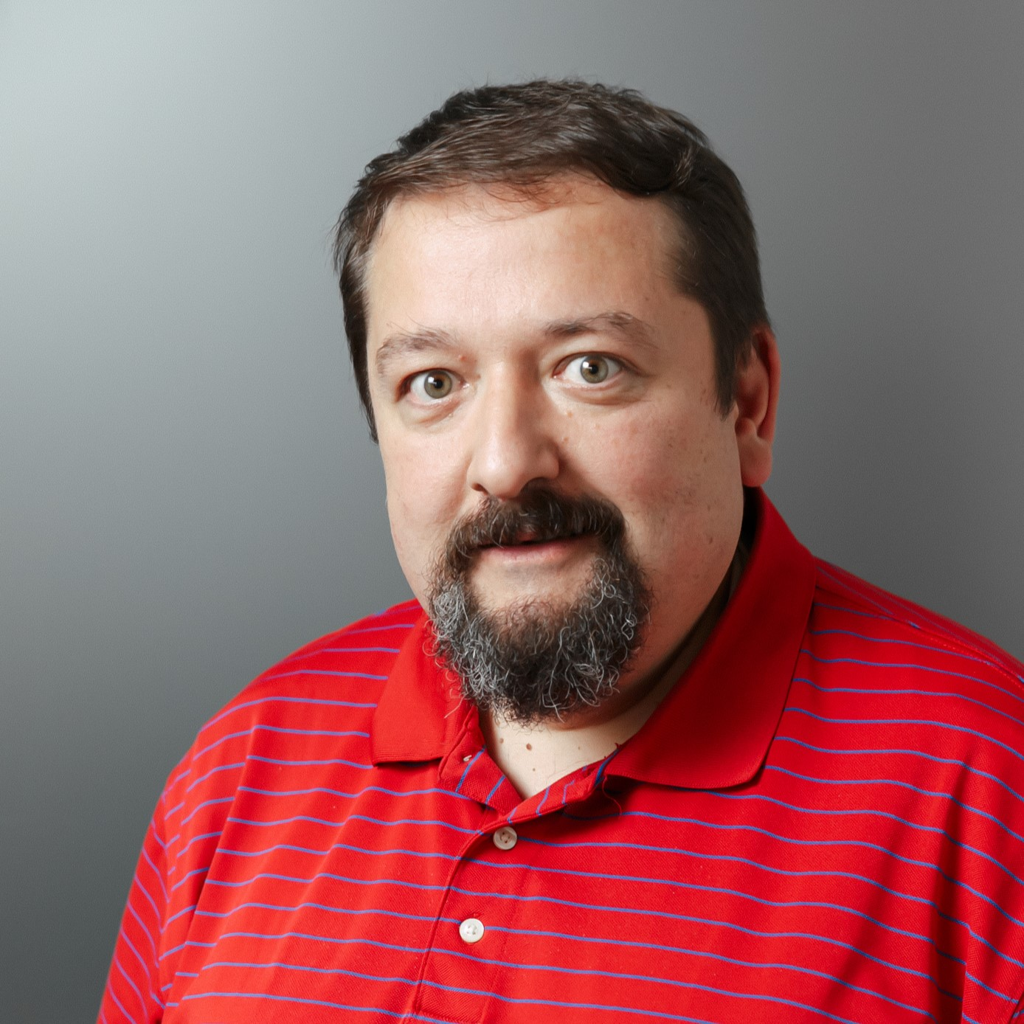

In [22]:
from shwars.utils import *
img = image_from_url("https://soshnikov.com/images/official/shwars_studio.jpg").resize((1024,1024))
img

In [23]:
res = vlm("Скажи комплимент человеку на фотографии, учитывая его внешний вид, возраст, выражение лица и одежду",img)
print(res)

Ваш внешний вид очень гармоничен и приятен. Ваша красная рубашка с полосками выглядит стильно и подчёркивает вашу уверенность. Ваше выражение лица излучает дружелюбие и открытость, что делает вас очень располагающим к общению человеком. Вы выглядите на свой возраст очень достойно и ухоженно.


VLM можно использовать для распознавания текста на картинке:

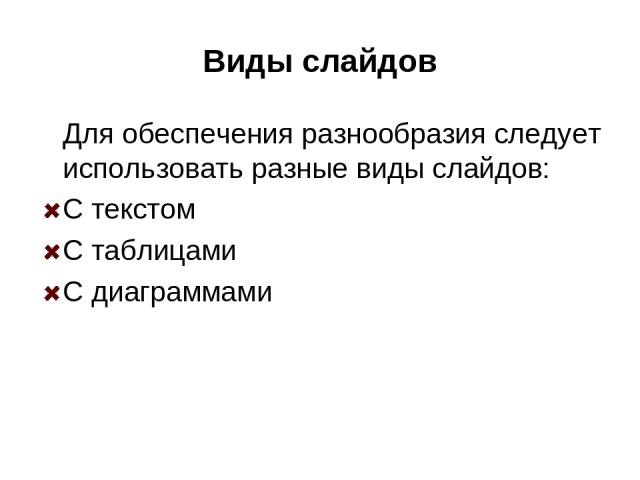

In [18]:
img = image_from_url("https://github.com/yandex-datasphere/jacademy/blob/main/2024/images/slide.jpg?raw=true")
img

In [20]:
res = vlm("Картинка содержит слайд с текстом. Выведи текст с этого слайда в формате Markdown",img)
print(res)

**Виды слайдов**

Для обеспечения разнообразия следует использовать разные виды слайдов:

- С текстом
- С таблицами
- С диаграммами


Нам также пригодятся функции для синтеза речи и рисования фотографий, которые мы видели раньше. Для этого понадобятся ключи для Yandex Cloud:

In [24]:
!wget https://storage.yandexcloud.net/ycpub/keys/.env

--2025-10-01 03:26:24--  https://storage.yandexcloud.net/ycpub/keys/.env
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 2a02:6b8::1d9, 213.180.193.243
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|2a02:6b8::1d9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80 [application/x-www-form-urlencoded]
Saving to: '.env'

     0K                                                       100% 42,4M=0s

2025-10-01 03:26:25 (42,4 MB/s) - '.env' saved [80/80]



In [25]:
from dotenv import load_dotenv
import os
load_dotenv()

folder_id  = os.environ['folder_id']
api_key = os.environ['api_key']

In [33]:
from speechkit import model_repository, configure_credentials, creds
from speechkit.stt import AudioProcessingType

# Аутентификация через API-ключ.
configure_credentials(
   yandex_credentials=creds.YandexCredentials(
      api_key=api_key
   )
)

def synthesize(text,voice='jane'):
   model = model_repository.synthesis_model()

   # Задайте настройки синтеза.
   model.voice = voice

   # Синтез речи и создание аудио с результатом.
   result = model.synthesize(text, raw_format=False)
   return result

def reco(bin):
    model = model_repository.recognition_model()
    model.model = 'general'
    model.language = 'ru-RU'
    model.audio_processing_type = AudioProcessingType.Full
    result = model.transcribe(bin)
    # можно использовать transcribe_file для распознавания файла с речью
    return ' '.join(x.normalized_text for x in result)

In [27]:
import io
from PIL import Image
from yandex_cloud_ml_sdk import YCloudML

sdk = YCloudML(folder_id=folder_id, auth=api_key)
yart_model = sdk.models.image_generation('yandex-art')

def generate(prompt):
    res = yart_model.run_deferred(prompt)
    res = res.wait()
    return Image.open(io.BytesIO(res.image_bytes))

Попробуем поиграть в испорченный телефон и попросим VLM передать картинку словами, и потом её нарисуем:

Сгенерируй изображение мужчины среднего возраста с короткими тёмными волосами и густой бородой, в которой присутствуют тёмные и седые оттенки. У него светлая кожа с небольшими веснушками. Мужчина одет в красную рубашку-поло с тонкими синими полосками. Фон изображения — нейтральный серый, без лишних деталей, что позволяет сосредоточить внимание на лице и верхней части тела мужчины. Освещение мягкое и равномерное, подчёркивающее черты лица и текстуру одежды. Выражение лица мужчины нейтральное, с лёгкой полуулыбкой.


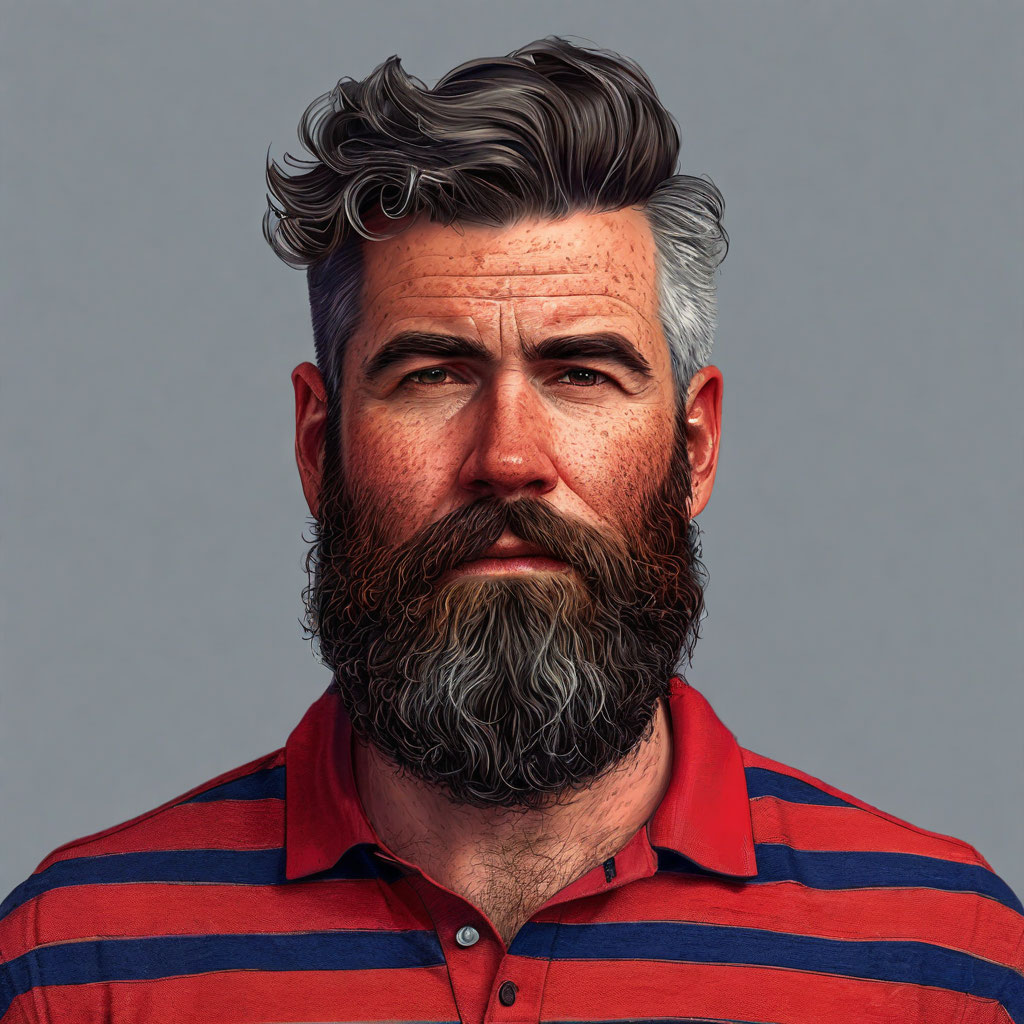

In [28]:
prompt = """
Опиши картинку как можно более подробно в виде промпта для генеративной диффузионной модели, чтобы по промпту можно было воссоздать исходную картинку
"""
img = image_from_url("https://soshnikov.com/images/official/shwars_studio.jpg").resize((1024,1024))

res = vlm(prompt,img)
print(res)

generate(res)

## Создаём телеграм-бота

Для интерфейса с пользователем удобно использовать телеграм-бота. Первым делом при создании бота нам необходимо создать бота в Telegram, используя специального системного бота **botfather**. Ему нужно дать команду **/newbot**, заполнить ряд полей, и получить в итоге специальный **токен** такого вида:

```
7292776300:AAGeoTIVI4pjNTxuCW7UckKck5G1ZNfFidw
```

Этот токен необходимо записать в переменную **tg_token** ниже.

После этого запустите ячейку ниже, описывающую простейшего бота:


In [ ]:
import telebot 

telegram_token = '<сюда поместите свой токен>'

bot = telebot.TeleBot(telegram_token)

# Обработчик команды /start
@bot.message_handler(commands=['start'])
def start(message):
    # Отправляем приветственное сообщение
    bot.send_message(message.chat.id,
                     'Привет, я бот, как дела?')

# Обработчик для сообщений, содержащих слово "анекдот"
@bot.message_handler(func=lambda message: 'анекдот' in message.text.lower())
def handle_anecdote(message):
    bot.send_message(message.chat.id, f"Вы хотите анекдот? А я их все забыл...")
    
# Обработчик для всех входящих сообщений
@bot.message_handler(func=lambda message: True)
def handle_message(message):
    bot.send_message(message.chat.id, f"Привет, вы сказали {message.text}.")
    
# Запуск бота
bot.polling(none_stop=True)

Ячейка выше будет выполняться бесконечно, пока вы явно её не остановите клавишей "стоп" (квадратик наверху). Пока ячейка работает - ваш бот в Telegram будет окликаться на сообщения. Когда вы останавливате ячейку, или DataSphere выклбчается - бот перестаёт работать. Чтобы он работал всегда - надо использовать более хитрые возможности Yandex Cloud, с которыми мы не будем знакомиться.

Попробуем сделать осмысленного бота. Он будет в ответ на картинку делать человеку комплимент, и пытаться нарисовать такую же картинку. В ответ на голосовое или текстовое сообщение он будет переспрашивать, что человек хочет. Такой бот показывает все возможные способы взаимодействия с телеграм.

In [34]:
import io
from PIL import Image

prompt_compliment = """
Скажи комплимент человеку на фотографии, учитывая его внешний вид, 
возраст, выражение лица и одежду
""".strip()

prompt_describe = """
Опиши картинку как можно более подробно в виде промпта для генеративной диффузионной модели, чтобы по промпту можно было воссоздать исходную картинку
""".strip()

bot = telebot.TeleBot(telegram_token)

# Обработчик команды /start
@bot.message_handler(commands=['start'])
def start(message):
    # Отправляем приветственное сообщение
    bot.send_message(message.chat.id,
                     'Привет, я бот-комплиментор, как дела?')

# Обработчик голосовых сообщений
@bot.message_handler(content_types=['voice'])
def handle_voice_message(message):
    # Получаем инфомацию о файле
    voice_file_info = bot.get_file(message.voice.file_id)
    # Скачиваем файл
    downloaded_file = bot.download_file(voice_file_info.file_path)
    res = reco(downloaded_file)
    bot.reply_to(message, f"Получено голосовое сообщение: {res}")

# Обработчик картинок
@bot.message_handler(content_types=['photo'])
def handle_image_message(message):
    highest_res_photo = message.photo[-1]  # Берём вариант фото с макс разрешением
    file_info = bot.get_file(highest_res_photo.file_id)
    # скачиваем файл
    downloaded_file = bot.download_file(file_info.file_path)
    # получаем картинку
    img = Image.open(io.BytesIO(downloaded_file))
    # делаем комплимент
    compl = vlm(prompt_compliment,img)
    bot.reply_to(message, compl)
    # отправляем комплимент голосовым
    audio_buffer = io.BytesIO()
    au = synthesize(compl,'julia')
    au.export(audio_buffer, format="ogg", codec="libopus")
    audio_buffer.seek(0)
    #bot.send_audio(message.chat.id, audio_buffer)
    bot.send_voice(message.chat.id, audio_buffer)
    # извлекаем промпт
    pr = vlm(prompt_describe,img)
    # рисуем картинку
    im = generate(pr)
    # отправляем
    bot.send_photo(message.chat.id, im)

# Обработчик для всех входящих сообщений
@bot.message_handler(func=lambda message: True)
def handle_message(message):
    bot.send_message(message.chat.id, f"Привет, вы сказали {message.text}.")
    
# Запуск бота
print("Бот готов к работе")
bot.polling(none_stop=True)

Бот готов к работе


## Создаём веб-приложение

Другой способ построения интерфейса приложения - это веб-приложение, к которому можно обратиться через интернет с помощью браузера. Для простых интерфейсов можно использоваться простую библиотеку [Gradio](https://www.gradio.app/). Напишем приложение, которое будет рисовать картинку по запросу.

Приложение устроено следующим образом:
* Мы описываем, как устроен интерфейс приложения, внутри команды `with gr.Blocks() as app`.
* Интерфейс можем содержать разные элементы: текст (`gr.Markdown`), строки для ввода текста (`gr.Textbox`), элементы для ввода или вывода изображений (`gr.Image`) и другие.
* Для разметки интерфейса используется **сетка**, состоящая из строк и столбцов.
   - Команда `with gr.Row():` означает начало строки. Все дальнейшие элементы будут располагаться в одной строке горизонтально
   - Команда `with gr.Column():` означает начало столбца, и все элементы внутри будут вертикальны
   - По умолчанию все элементы внутри `gr.Blocks()` располагаются вертикально
* Для запуска приложения используем кнопку `gr.Button()`, при этом задаём **обработчик события** на нажатие кнопки командой `btn.click`. Мы указываем, какую функцию надо вызвать (`fn=...`), какие аргументы передать ей на вход (`inputs=...`, в нашем случае это поле ввода `inp`), и куда надо записать результат функции (`outputs=...`, в нашем случае - это поле с картинкой `outp`).

Когда приложение запускается, с ним можно работать прямо из DataSphere, либо из любого браузера, подключенного к интернету. При запуске приложение выдает примерно такую строчку:
```
Running on public URL: https://b245e0aa5f432b4f65.gradio.live
```
По этому адресу любой желающий может подключиться к приложению - но только пока у нас работает ячейка в DataSphere.


In [36]:
import gradio as gr

def run(prompt,style):
    return generate(prompt+' в стиле '+style)

with gr.Blocks() as app:
    gr.Markdown('## Рисовалка')
    gr.Markdown('Это приложение нарисует вам картинку')
    with gr.Row(): # Начинаем строчку интерфейса
        with gr.Column():
            inp = gr.Textbox(placeholder='Напиши, что нарисовать', label='Промпт')
            style = gr.Dropdown(['Ван гог','Куинджи','Стимпанк'])
        outp = gr.Image(label='Результат')
    btn = gr.Button("Нарисовать")
    btn.click(fn=run,inputs=[inp,style],outputs=outp)
    
app.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


## Мораль

VML-ка открывает неограниченные возможности по работе с изображениями!

В Google Colab / Datasphere можно строить простые интерфейсы, которые будут работать до тех пор, пока запущена соответствующая ячейка. Это удобно использовать для демонстраций, проверки proof of concept и т.д. Для более надёжного размещения в облаке желательно использовать облачные функции или виртуальные машины, т.е. призывать специалиста.